In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import sys
sys.path.append('/repo')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [20]:

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),  # Resize to 48x48
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=0, scale=(1, 1.2)),  # Random zoom: 80% to 120% of the original size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(root='./FerPlus/fer2013plus/fer2013/train/', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='./FerPlus/fer2013plus/fer2013/test/', transform=val_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

# Check if the DataLoader works as expected
for images, labels in train_loader:
    print(images.size(), labels.size())
    break


torch.Size([64, 1, 48, 48]) torch.Size([64])


In [21]:
# Basic info about the datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Class labels
print(f"Class labels: {train_dataset.classes}")

# Number of classes
print(f"Number of classes: {len(train_dataset.classes)}")


Number of training samples: 27378
Number of validation samples: 6824
Class labels: ['anger', 'happiness', 'neutral', 'sadness', 'surprise']
Number of classes: 5


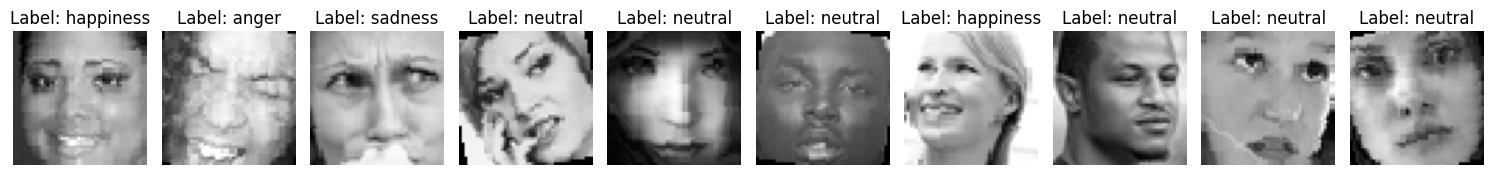

In [5]:

# Function to show images in a grid
def show_images_grid(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        ax = axes[i]
        image = images[i].numpy().squeeze()  # Remove extra dimension for grayscale
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
        ax.axis('off')  # Remove axes ticks
    
    plt.tight_layout()
    plt.show()

# Display a grid of images from the training set
for images, labels in train_loader:
    show_images_grid(images, labels, num_images=10)
    break


### Distribución de FERplus original

Training set class distribution: Counter({5: 10308, 4: 7528, 7: 3562, 6: 3514, 0: 2466, 3: 652, 2: 191, 1: 165})


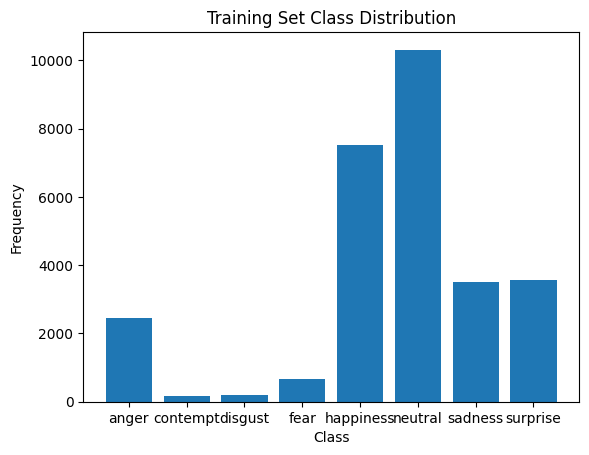

In [23]:
from collections import Counter

# Get the class distribution in the training set
val_labels = [label for _, label in train_dataset.samples]
class_distribution = Counter(val_labels)

# Print class distribution
print(f"Training set class distribution: {class_distribution}")

# Visualize class distribution
plt.bar(train_dataset.classes, class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Training Set Class Distribution')
plt.show()
28386



### Distribución sin clase: "contempt", "disgust" y "fear"

Training set class distribution: Counter({2: 10308, 1: 7528, 4: 3562, 3: 3514, 0: 2466})


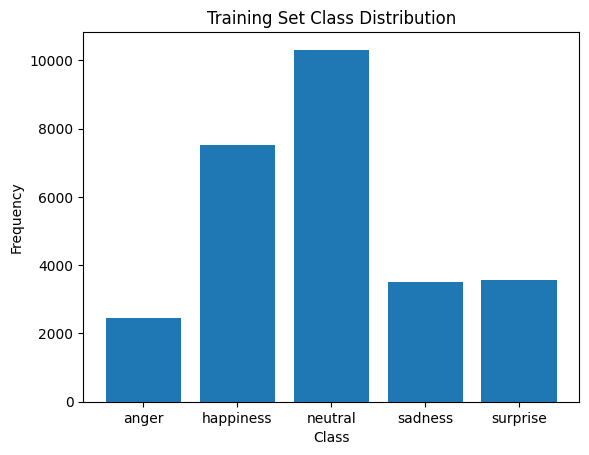

In [7]:
from collections import Counter
# Get the class distribution in the training set
val_labels = [label for _, label in train_dataset.samples]
class_distribution = Counter(val_labels)

# Print class distribution
print(f"Training set class distribution: {class_distribution}")

# Visualize class distribution
plt.bar(train_dataset.classes, class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Training Set Class Distribution')
plt.show()

### SubSampling

Number of samples in the undersampled training dataset: 12330
Subsampled Training set class distribution: Counter({0: 2466, 1: 2466, 2: 2466, 3: 2466, 4: 2466})


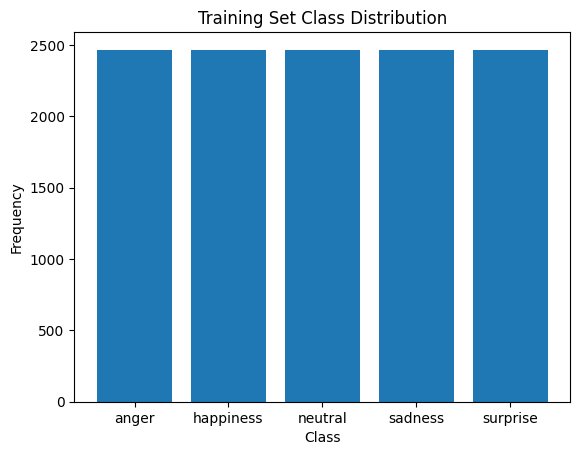

In [12]:
import numpy as np
from torch.utils.data import Subset

def undersample_imagefolder_dataset(dataset):
    # Count number of samples per class
    class_counts = np.bincount([label for _, label in dataset.samples])
    min_class_count = min(class_counts)  # Find the minimum number of samples in any class
    
    # Create an array to hold indices of selected samples for each class
    undersample_indices = []
    
    # Loop over each class and randomly select 'min_class_count' samples
    for class_idx in range(len(class_counts)):
        class_indices = np.where(np.array([label for _, label in dataset.samples]) == class_idx)[0]
        np.random.shuffle(class_indices)  # Shuffle indices for random selection
        undersample_indices.extend(class_indices[:min_class_count])  # Take min_class_count samples from each class
    
    # Subset the dataset based on the undersampled indices
    undersampled_samples = [dataset.samples[i] for i in undersample_indices]
    
    # Create a new ImageFolder-like dataset with the undersampled data
    undersampled_dataset = datasets.ImageFolder(root=dataset.root, transform=dataset.transform)
    undersampled_dataset.samples = undersampled_samples
    undersampled_dataset.targets = [s[1] for s in undersampled_samples]  # Update the targets list

    return undersampled_dataset

# Apply undersampling to your training dataset
train_dataset = datasets.ImageFolder(root='./FerPlus/fer2013plus/fer2013/train/', transform=train_transforms)
undersampled_train_dataset = undersample_imagefolder_dataset(train_dataset)

# Create DataLoader for the undersampled dataset
train_loader_undersampled = DataLoader(undersampled_train_dataset, batch_size=128, shuffle=True, num_workers=4)

# Check the size of the undersampled dataset
print(f"Number of samples in the undersampled training dataset: {len(undersampled_train_dataset)}")

train_labels = [label for _, label in undersampled_train_dataset.samples]
class_distribution = Counter(train_labels)

# Print class distribution
print(f"Subsampled Training set class distribution: {class_distribution}")

# Visualize class distribution
plt.bar(undersampled_train_dataset.classes, class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Training Set Class Distribution')
plt.show()